# Session 3 — Sentence-Level Analysis
## Measure 1: Sentence Length & Distribution
This notebook helps you split your text into sentences and compute:
- number of sentences
- average sentence length (in tokens and in characters)
- distribution / histogram of sentence lengths
- comparison across two texts/authors

Like before, we'll analyze Lewis Carroll's two Alice books as our example texts:
- Alice's Adventures in Wonderland
- Through the Looking-Glass

In [1]:
import re, os
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

# Set plot styles
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# --- Configuration ---
CONFIG = {
    "book1_path": "..\\data\\Fellowship.txt",
    "book2_path": "..\\data\\TwoTowers.txt",
    "book3_path": "..\\data\\TheKing.txt",
    "book1_name": "Fellowship",
    "book2_name": "Two Towers",
    "book3_name": "Return of the King",
    "min_sentence_len": 3, # Min words in a sentence to be counted
}

# Create results directory
Path("../results").mkdir(exist_ok=True)

print("Cell 1: Imports and Config loaded.")

Cell 1: Imports and Config loaded.


In [9]:
# --- Robust Text Loading Functions (from our previous projects) ---
# The simple 'load_book' from the Alice example is not strong enough
# to handle the Foreword/Prologue in Fellowship. We'll use our
# proven 'strip_gutenberg' function.

_GB_START_MARKERS = [
    r"\*\*\*\s*START OF (THIS|THE) PROJECT GUTENBERG EBOOK",
    r"START OF (THIS|THE) PROJECT GUTENBERG EBOOK",
]
_GB_END_MARKERS = [
    r"\*\*\*\s*END OF (THIS|THE) PROJECT GUTENBERG EBOOK",
    r"END OF (THIS|THE) PROJECT GUTENBERG EBOOK",
]

# === FIX: Re-ordered hints to be most-specific-first ===
# This prevents the code from matching "CHAPTER I" in the Prologue
# before it finds the *real* start of the book.
_CHAPTER_HINTS = [
    r"^\s*A LONG-EXPECTED PARTY\s*$", # Start of Fellowship
    r"^\s*The Departure of Boromir\s*$", # Start of Two Towers
    r"^\s*Minas Tirith\s*$", # Start of Return of King
    r"^\s*CHAPTER I\s*$", # Generic fallback
    r"^\s*BOOK I\s*$", # Generic fallback
]

def strip_gutenberg(text: str) -> str:
    """
    Returns text between Gutenberg START and END markers (case-insensitive).
    If markers aren't found, heuristically trims to first chapter-like heading.
    """
    t = text.replace("\ufeff", "") 
    start_idx, end_idx = None, None
    for pat in _GB_START_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            start_idx = t.find("\n", m.end())
            if start_idx == -1: start_idx = m.end()
            break
    for pat in _GB_END_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            end_idx = m.start()
            break
    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        core = t[start_idx:end_idx]
    else: 
        core = t
        # Fallback: try to start at first chapter-like heading
        found_start = False
        for pat in _CHAPTER_HINTS:
            m = re.search(pat, core, flags=re.IGNORECASE | re.MULTILINE)
            if m: 
                core = core[m.start():]
                found_start = True
                break
        # If using hints, also trim the standard license tail
        if found_start:
            for pat in _GB_END_MARKERS:
                 m = re.search(pat, core, flags=re.IGNORECASE)
                 if m:
                     core = core[:m.start()]
                     break
    return core.strip()

def load_text(p: str) -> str:
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def normalize_text(t: str) -> str:
    """Cleans text: strips Gutenberg, normalizes whitespace."""
    t = strip_gutenberg(t)
    # Replace line breaks with spaces, then collapse whitespace
    t = re.sub(r"[\r\n]+", " ", t)
    t = re.sub(r"\s+", " ", t)
    return t

print("Cell 2: Helper functions defined (with improved hints).")

Cell 2: Helper functions defined (with improved hints).


In [10]:
def analyze_sentences(text, book_name, min_len=3):
    """Split text into sentences and analyze lengths"""
    # Split on sentence boundaries (., !, ?)
    sentences = re.split(r'[.!?]+\s+', text.strip())
    
    # Filter out empty strings and very short "sentences"
    sentences = [s.strip() for s in sentences if s.strip()]
    lengths_tokens = [len(s.split()) for s in sentences if len(s.split()) >= min_len]
    lengths_chars = [len(s) for s in sentences if len(s.split()) >= min_len]
    
    if not lengths_tokens:
        print(f"ERROR: No sentences found for {book_name}. Check stripping function.")
        return [], [], []

    print(f"\n{'='*70}")
    print(f"{book_name}")
    print(f"{'='*70}")
    print(f"Number of sentences (>= {min_len} words): {len(lengths_tokens):,}")
    print(f"Avg sentence length (tokens): {np.mean(lengths_tokens):.2f}")
    print(f"Median sentence length (tokens): {np.median(lengths_tokens):.0f}")
    print(f"Max sentence length (tokens): {np.max(lengths_tokens)}")
    
    return sentences, lengths_tokens, lengths_chars

# --- Load and Analyze All Three Books ---
print("Loading and cleaning texts...")
text1 = normalize_text(load_text(CONFIG["book1_path"]))
text2 = normalize_text(load_text(CONFIG["book2_path"]))
text3 = normalize_text(load_text(CONFIG["book3_path"]))

print(f"{CONFIG['book1_name']} loaded: {len(text1):,} chars")
print(f"{CONFIG['book2_name']} loaded: {len(text2):,} chars")
print(f"{CONFIG['book3_name']} loaded: {len(text3):,} chars")

# Analyze all three
sents1, tokens1, chars1 = analyze_sentences(text1, CONFIG["book1_name"], CONFIG["min_sentence_len"])
sents2, tokens2, chars2 = analyze_sentences(text2, CONFIG["book2_name"], CONFIG["min_sentence_len"])
sents3, tokens3, chars3 = analyze_sentences(text3, CONFIG["book3_name"], CONFIG["min_sentence_len"])

Loading and cleaning texts...
Fellowship loaded: 943,442 chars
Two Towers loaded: 817,506 chars
Return of the King loaded: 709,668 chars

Fellowship
Number of sentences (>= 3 words): 10,534
Avg sentence length (tokens): 16.87
Median sentence length (tokens): 14
Max sentence length (tokens): 142

Two Towers
Number of sentences (>= 3 words): 10,141
Avg sentence length (tokens): 15.15
Median sentence length (tokens): 12
Max sentence length (tokens): 89

Return of the King
Number of sentences (>= 3 words): 7,201
Avg sentence length (tokens): 18.73
Median sentence length (tokens): 15
Max sentence length (tokens): 142


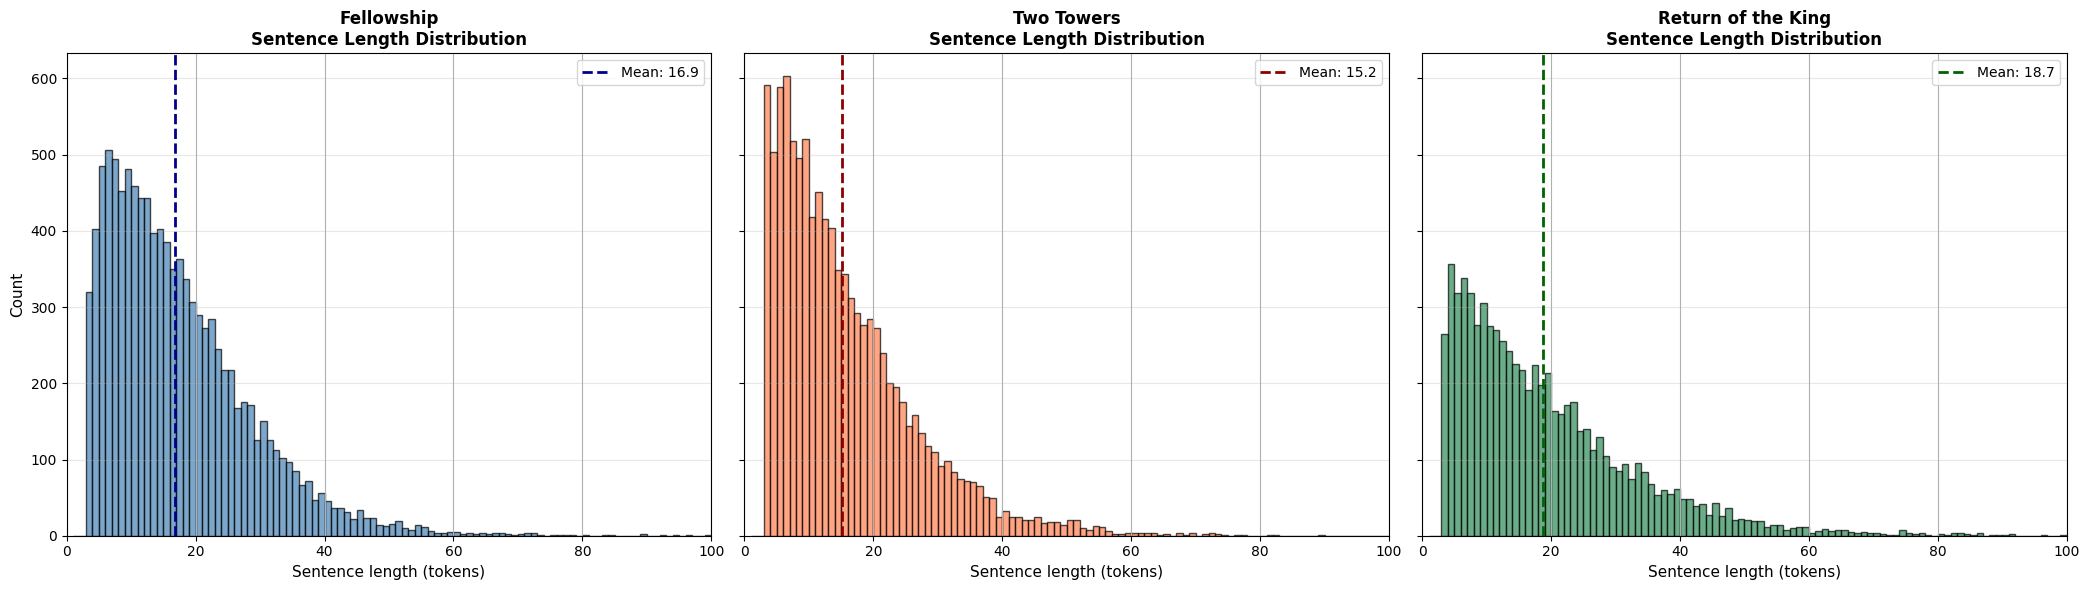

In [14]:
# Visualize sentence length distributions for all three books
fig, axes = plt.subplots(1, 3, figsize=(21, 6), sharey=True) # Changed to 1x3 and sharing y-axis

# --- Book 1: Fellowship ---
ax1 = axes[0]
ax1.hist(tokens1, bins=range(1, 101), alpha=0.7, color='steelblue', edgecolor='black')
ax1.set_xlabel('Sentence length (tokens)', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title(f"{CONFIG['book1_name']}\nSentence Length Distribution", fontsize=12, fontweight='bold')
ax1.axvline(np.mean(tokens1), color='darkblue', linestyle='--', linewidth=2, label=f'Mean: {np.mean(tokens1):.1f}')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_xlim(0, 100) # Set common x-limit for readability

# --- Book 2: Two Towers ---
ax2 = axes[1]
ax2.hist(tokens2, bins=range(1, 101), alpha=0.7, color='coral', edgecolor='black')
ax2.set_xlabel('Sentence length (tokens)', fontsize=11)
ax2.set_title(f"{CONFIG['book2_name']}\nSentence Length Distribution", fontsize=12, fontweight='bold')
ax2.axvline(np.mean(tokens2), color='darkred', linestyle='--', linewidth=2, label=f'Mean: {np.mean(tokens2):.1f}')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xlim(0, 100) # Set common x-limit

# --- Book 3: Return of the King ---
ax3 = axes[2]
ax3.hist(tokens3, bins=range(1, 101), alpha=0.7, color='seagreen', edgecolor='black')
ax3.set_xlabel('Sentence length (tokens)', fontsize=11)
ax3.set_title(f"{CONFIG['book3_name']}\nSentence Length Distribution", fontsize=12, fontweight='bold')
ax3.axvline(np.mean(tokens3), color='darkgreen', linestyle='--', linewidth=2, label=f'Mean: {np.mean(tokens3):.1f}')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_xlim(0, 100) # Set common x-limit

plt.tight_layout()
fig.savefig("../results/sentence_length_histograms.png", dpi=200, bbox_inches="tight")
plt.show()

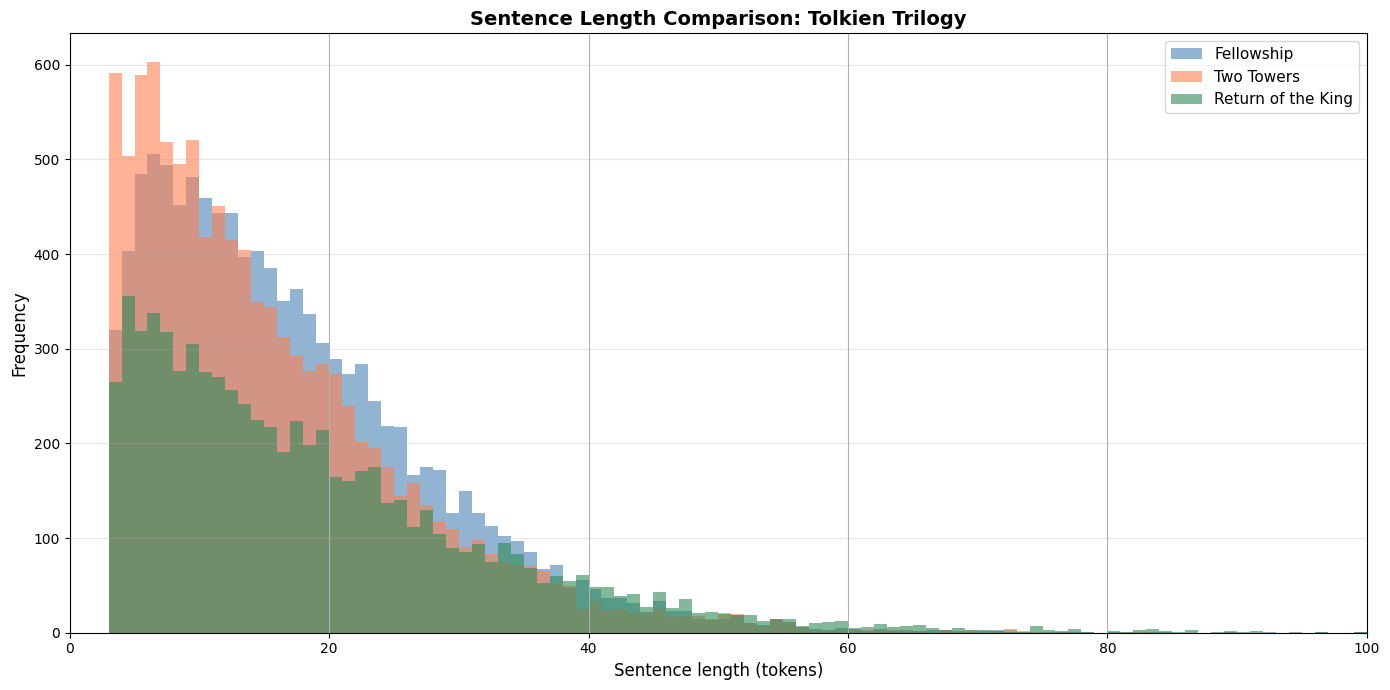

In [15]:
# Compare all three books overlaid
fig, ax = plt.subplots(figsize=(14, 7))

# Set a common bin range for comparison
bins = range(1, 101) # Cap at 100 for readability

ax.hist(tokens1, bins=bins, alpha=0.6, color='steelblue', label=CONFIG['book1_name'])
ax.hist(tokens2, bins=bins, alpha=0.6, color='coral', label=CONFIG['book2_name'])
ax.hist(tokens3, bins=bins, alpha=0.6, color='seagreen', label=CONFIG['book3_name'])
        
ax.set_xlabel('Sentence length (tokens)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Sentence Length Comparison: Tolkien Trilogy', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_xlim(0, 100) # Focus on the main distribution

plt.tight_layout()
fig.savefig("../results/sentence_length_overlay.png", dpi=200, bbox_inches="tight")
plt.show()

In [17]:
# Statistical comparison

# --- Create safe helper function to avoid errors on empty lists ---
def safe_stat(token_list, func, default=0):
    if not token_list:
        return default
    try:
        return func(token_list)
    except ValueError:
        return default

# --- Safely calculate stats for each book ---
stats1 = {
    'Mean sentence length': safe_stat(tokens1, np.mean),
    'Median sentence length': safe_stat(tokens1, np.median),
    'Standard Deviation': safe_stat(tokens1, np.std),
    'Shortest sentence (words)': safe_stat(tokens1, np.min),
    'Longest sentence (words)': safe_stat(tokens1, np.max),
    'Total sentences': len(tokens1)
}
stats2 = {
    'Mean sentence length': safe_stat(tokens2, np.mean),
    'Median sentence length': safe_stat(tokens2, np.median),
    'Standard Deviation': safe_stat(tokens2, np.std),
    'Shortest sentence (words)': safe_stat(tokens2, np.min),
    'Longest sentence (words)': safe_stat(tokens2, np.max),
    'Total sentences': len(tokens2)
}
stats3 = {
    'Mean sentence length': safe_stat(tokens3, np.mean),
    'Median sentence length': safe_stat(tokens3, np.median),
    'Standard Deviation': safe_stat(tokens3, np.std),
    'Shortest sentence (words)': safe_stat(tokens3, np.min),
    'Longest sentence (words)': safe_stat(tokens3, np.max),
    'Total sentences': len(tokens3)
}

# --- Create the DataFrame ---
df_stats = pd.DataFrame({
    CONFIG['book1_name']: stats1,
    CONFIG['book2_name']: stats2,
    CONFIG['book3_name']: stats3
})
df_stats.index.name = 'Metric'


# --- Format for readability ---
# Note: Transpose (.T) the DataFrame for this formatting logic
df_formatted = df_stats.T.style.format({
    'Mean sentence length': '{:,.2f}',
    'Median sentence length': '{:,.0f}',
    'Standard Deviation': '{:,.2f}',
    'Shortest sentence (words)': '{:,.0f}',
    'Longest sentence (words)': '{:,.0f}',
    'Total sentences': '{:,.0f}'
})

print("\n" + "="*70)
print("COMPARATIVE STATISTICS")
print("="*70)

# Save table to CSV (saving the un-styled, original orientation)
df_stats.to_csv("../results/sentence_stats_comparison.csv")
print("Saved stats table to ../results/sentence_stats_comparison.csv")

# Display the formatted, transposed table
df_formatted


COMPARATIVE STATISTICS
Saved stats table to ../results/sentence_stats_comparison.csv


Metric,Mean sentence length,Median sentence length,Standard Deviation,Shortest sentence (words),Longest sentence (words),Total sentences
Fellowship,16.87,14,11.18,3,142,"10,534"
Two Towers,15.15,12,10.75,3,89,"10,141"
Return of the King,18.73,15,14.03,3,142,"7,201"


In [18]:
# Statistical comparison

# --- Create safe helper function to avoid errors on empty lists ---
def safe_stat(token_list, func, default=0):
    if not token_list:
        return default
    try:
        return func(token_list)
    except ValueError:
        return default

# --- Safely calculate stats for each book ---
stats1 = {
    'Mean sentence length': safe_stat(tokens1, np.mean),
    'Median sentence length': safe_stat(tokens1, np.median),
    'Standard Deviation': safe_stat(tokens1, np.std),
    'Shortest sentence (words)': safe_stat(tokens1, np.min),
    'Longest sentence (words)': safe_stat(tokens1, np.max),
    'Total sentences': len(tokens1)
}
stats2 = {
    'Mean sentence length': safe_stat(tokens2, np.mean),
    'Median sentence length': safe_stat(tokens2, np.median),
    'Standard Deviation': safe_stat(tokens2, np.std),
    'Shortest sentence (words)': safe_stat(tokens2, np.min),
    'Longest sentence (words)': safe_stat(tokens2, np.max),
    'Total sentences': len(tokens2)
}
stats3 = {
    'Mean sentence length': safe_stat(tokens3, np.mean),
    'Median sentence length': safe_stat(tokens3, np.median),
    'Standard Deviation': safe_stat(tokens3, np.std),
    'Shortest sentence (words)': safe_stat(tokens3, np.min),
    'Longest sentence (words)': safe_stat(tokens3, np.max),
    'Total sentences': len(tokens3)
}

# --- Create the DataFrame ---
df_stats = pd.DataFrame({
    CONFIG['book1_name']: stats1,
    CONFIG['book2_name']: stats2,
    CONFIG['book3_name']: stats3
})
df_stats.index.name = 'Metric'


# --- Format for readability ---
# Note: Transpose (.T) the DataFrame for this formatting logic
df_formatted = df_stats.T.style.format({
    'Mean sentence length': '{:,.2f}',
    'Median sentence length': '{:,.0f}',
    'Standard Deviation': '{:,.2f}',
    'Shortest sentence (words)': '{:,.0f}',
    'Longest sentence (words)': '{:,.0f}',
    'Total sentences': '{:,.0f}'
})

print("\n" + "="*70)
print("COMPARATIVE STATISTICS")
print("="*70)

# Save table to CSV (saving the un-styled, original orientation)
df_stats.to_csv("../results/sentence_stats_comparison.csv")
print("Saved stats table to ../results/sentence_stats_comparison.csv")

# Display the formatted, transposed table
df_formatted


COMPARATIVE STATISTICS
Saved stats table to ../results/sentence_stats_comparison.csv


Metric,Mean sentence length,Median sentence length,Standard Deviation,Shortest sentence (words),Longest sentence (words),Total sentences
Fellowship,16.87,14,11.18,3,142,"10,534"
Two Towers,15.15,12,10.75,3,89,"10,141"
Return of the King,18.73,15,14.03,3,142,"7,201"
